In [41]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [42]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [43]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

In [44]:
from implementations import *

# Exploratory analysis

Feature 2:


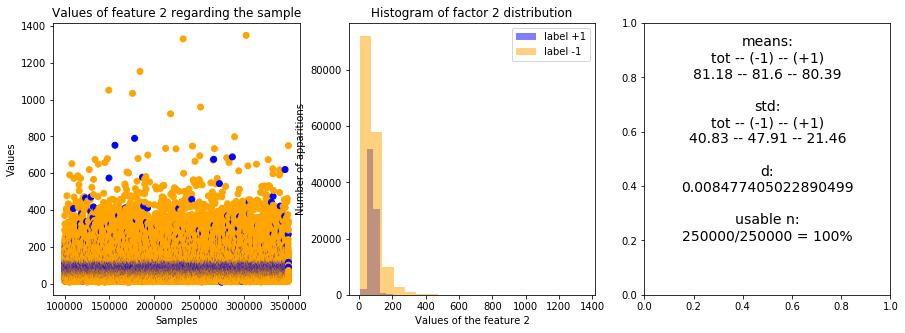

Feature 6:


C:\Users\Christelle\Anaconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Christelle\Anaconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


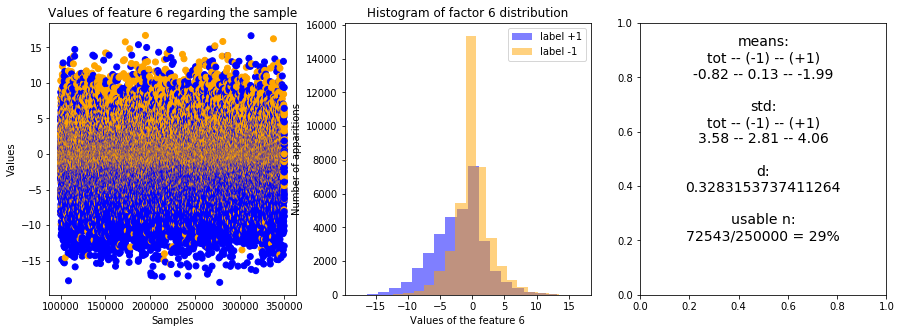

Feature 10:


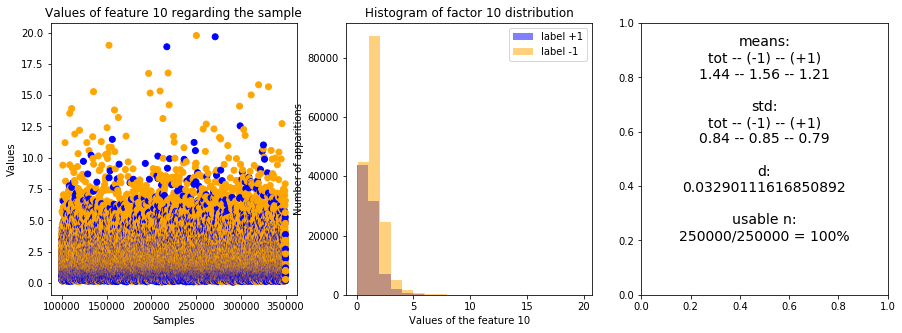

Feature 15:


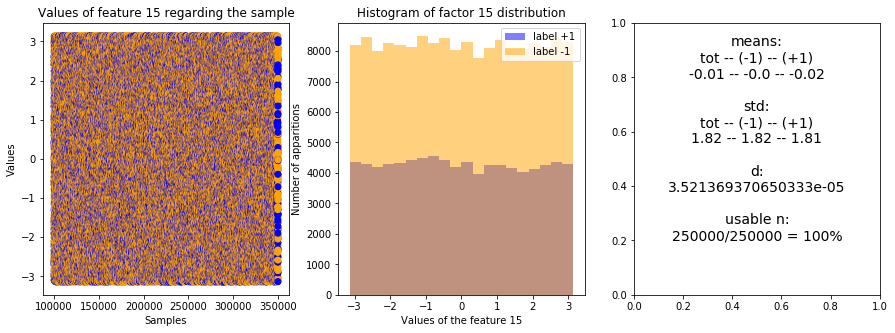

Feature 20:


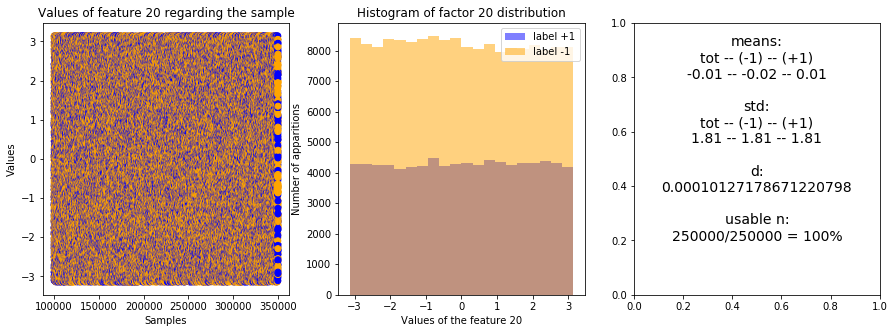

Feature 27:


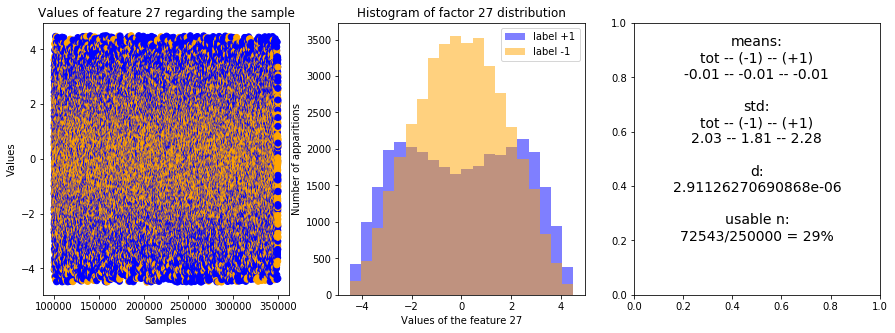

In [5]:
tX0 = np.where(tX==-999, np.nan,tX)

for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Data pre-processing 

So for the data pre-processing, the first step is to remove the visible outliers in the Exploratory Analysis plots. 

In [45]:
# remove outliers based on the plots in the Exploratory analysis
y, tX = remove_outliers(y, tX, [0, 2, 3, 8, 13, 16, 19, 21, 23, 26],
                       [1100, 1000, 1000, 2500, 500, 500, 800, 1800, 800, 600])

# Feature processing

Then with this data, we separate the data points based on the categorical data: jet. We keep three matrices with `jet = 0`, `jet = 1` and `jet > 2`. We will futher train separately our models on each of these sub-matrices and have separated, learning rates, penalities or polynomial degrees for each. 

We still keep the whole data matrix to do the same treatments and generate whole weight matrices as a comparison. 

In [46]:
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

For each dataset, we clean them by setting all missing values `-999` to `NaN`, then when for a feature the ratio of missing values reaches a threshold, we remove the whole feature from the dataset. The remaining missing data are replaced by the median value in the column (we also tried to replace the missing data by the mean value of the feature or a gaussian distribution. Then we standarize the data. 

In [47]:
# remove categorical data
tX = np.delete(tX, 22, axis=1)
# keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX, degree = 1, cutoff = 0.95, imputation = impute_median, interaction = False)
# standarize the data
rmX = np.append(rmX, 22)
tX = np.apply_along_axis(standardize, 1, tX)

In [48]:
tX_jet0, rmX_jet0 = train_data_formatting(tX_jet0, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
tX_jet1, rmX_jet1 = train_data_formatting(tX_jet1, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
tX_jet2, rmX_jet2 = train_data_formatting(tX_jet2, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
tX_jet0 = np.apply_along_axis(standardize, 1, tX_jet0)
tX_jet1 = np.apply_along_axis(standardize, 1, tX_jet1)
tX_jet2 = np.apply_along_axis(standardize, 1, tX_jet2)

In [49]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

print("\nremoved columns for :\ntX={rmX}\ntX_jet0={rmX0}\ntX_jet1={rmX1}\ntX_jet2+={rmX2}".format(
    rmX=rmX, rmX0=rmX_jet0, rmX1=rmX_jet1, rmX2=rmX_jet2))

tX shape=(249987, 29)
tX_jet0 shape=(99911, 19)
tX_jet1 shape=(77542, 22)
tX_jet2+ shape=(72534, 29)

removed columns for :
tX=[22]
tX_jet0=[ 4  5  6 12 22 23 24 25 26 27]
tX_jet1=[ 4  5  6 12 25 26 27]
tX_jet2+=[]


## Least squares

### Full dataset

In [10]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[-35.68721009 -36.23354854 -36.26646299 -35.64727188 -55.81226583
 -35.50669185 -36.12072332 -15.25225736 -35.82859467 -30.33523537
 -51.82400988 -32.17048871 -11.89203905 -40.3779591  -35.7013805
 -35.7449714  -40.17070508 -35.74281401 -35.64531643 -35.49532654
 -35.7235873  -35.7740973  -35.82507492 -35.71597192 -35.77858779
 -36.92251118 -35.63186513 -35.92721705 -41.10793904]

mse=0.3336375995143341


### Jet sub-datasets

In [11]:
for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    (w_ls, loss_ls) = least_squares(yi, txi)
    print("w_jet{jet}* = {w}\nmse = {loss}\n\n".format(
    jet=index_jet, w=w_ls, loss=loss_ls))

w_jet0* = [  78.74379268   78.30898626   78.39409504  630.61544509   89.3205278
 -473.25593465   63.13287081   61.42076287   81.2059743    94.80600656
   78.8300112    78.77038882   95.25224768   78.97009965   78.7822777
   78.90061176   78.6616956    78.75056023   67.35144986]
mse = 0.2697132203328646


w_jet1* = [    8.68230359     8.17135943     8.29213346     8.45949033
    13.06158599     8.73775384     3.20147709   -11.95074942
    13.42980178    14.23967933     8.78379751     8.49723237
    14.86090668     8.3562064      8.6098176      8.74233082
     8.66573971     8.5174743  -2718.90399275     8.60974173
     8.54131505  2741.64465122]
mse = 0.3775884027409172


w_jet2* = [  0.76632494   0.25873084   0.29987857   0.95584426 -18.41242172
   0.93478697   1.13302818  17.04292927   0.55735078   7.59799565
 -16.57128172   6.87357074  27.09903338  -5.63430688   0.33230349
   0.74451525  -5.33139928   0.33305405   0.93704453   0.87034518
   1.02228797   0.55723111   0.51016526   0.93

## Least squares with Gradient Descent

### Full dataset

In [12]:
#define parameters
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

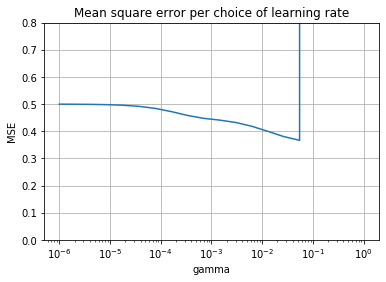

In [13]:
#plot the losses per gamma
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [14]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w* =[ 0.0126199  -0.48647446 -0.03047794  0.11520304  0.03248214  0.0649263
  0.02940488  0.03433868 -0.03442777  0.04272002  0.0229709   0.04639054
  0.03443587  0.20130906  0.03442594  0.03376876 -0.08106557  0.0345464
  0.03493935 -0.07624042  0.03493486 -0.05834902 -0.06300652  0.03446513
  0.03451183 -0.10864717  0.03453567  0.0343125  -0.00855291]

mse=0.366710657658682

gamma=0.05455594781168514


### Jet sub-datasets

In [15]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    initial_w = np.zeros(txi.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_GD(yi, txi, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [-0.01268966 -0.45286053 -0.03060604 -0.02288706  0.04505707 -0.02288706
  0.13402538  0.03142021  0.04668328  0.22226987  0.04118993  0.04004651
 -0.04742493  0.04187028  0.04152246 -0.12771445  0.03984439 -0.00767919
  0.04081952]
mse = 0.2845205660383143
gamma = 0.046415888336127725
w_jet1* = [ 0.06504209 -0.40400458 -0.07024927  0.02921431  0.02466132  0.04392747
  0.0433372   0.01425258  0.03934198  0.16509277  0.02572275  0.02477945
 -0.10568337  0.02507639  0.02625812 -0.03827485  0.02676426 -0.05807246
  0.03578826  0.02565433  0.02558297  0.03578828]
mse = 0.39670516808490924
gamma = 0.046415888336127725
w_jet2* = [ 0.0786871  -0.27834956 -0.02054902  0.23971003  0.00535617  0.13466436
  0.00876728  0.00703933 -0.0979903  -0.02926379  0.00158192  0.01565398
  0.00906699  0.16080294  0.00714831  0.00751429 -0.03246758  0.00718067
  0.00811181  0.0248272   0.00882652 -0.12216758 -0.00787447  0.00803732
  0.00779883 -0.0247758   0.00785386  0.0070685  -0.14225931]
mse =

## Least squares with Stochastic Gradient Descent

### Full dataset

In [16]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

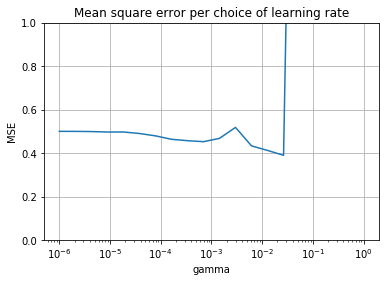

In [17]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [18]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w*={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

w*=[ 0.00221634 -0.49080568  0.02986221  0.20787263  0.03753301  0.0886886
  0.02765994  0.03505043 -0.0728258  -0.01111182  0.02030813  0.05655527
  0.0373755   0.2372228   0.033616    0.03738138 -0.15079909  0.03400424
  0.03517339 -0.02693321  0.0532001  -0.15095291 -0.0446802   0.03172361
  0.03497173 -0.13896651  0.03565739  0.03467939 -0.02367687]

mse=0.38948123916629773

gamma=0.026366508987303555


### Jet sub-datasets

In [19]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    initial_w = np.zeros(txi.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_SGD(yi, txi, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [-0.0532687  -0.08263936 -0.02098198  0.01431572  0.02327984  0.01431572
 -0.02409455  0.02270249  0.02675511  0.0134965   0.02532452  0.02500852
 -0.01285942  0.02513601  0.02464225 -0.03256386  0.02529798 -0.03859853
  0.02473174]
mse = 0.35717975507307315
gamma = 0.002154434690031882
w_jet1* = [-0.02635288 -0.21548435 -0.05798105  0.04780401  0.01506752  0.00869046
  0.00613393  0.01169062  0.02576306  0.09148829  0.01944797  0.01704449
 -0.06527848  0.01871233  0.02196455 -0.03769561  0.02112228  0.04253309
  0.01491266  0.01481437  0.01069007  0.01491266]
mse = 0.4355849065472139
gamma = 0.01
w_jet2* = [-0.02778284 -0.01432959 -0.02467088  0.00186429  0.00875971  0.0687868
  0.00790199  0.00786653 -0.00872223 -0.03988825  0.00768856  0.00902641
  0.00862919  0.01085169  0.00796912  0.00898494 -0.00676833  0.00797639
  0.00804202  0.00377341  0.00856923 -0.05729181 -0.00473228  0.00786845
  0.00870327  0.00140333  0.0080988   0.00842633 -0.02700427]
mse = 0.45025254958437

## Ridge regression

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation that optimizes both at the same time. 

Then a biais and variance decomposition is used to visualize if the methods tend to underfit or overfit. 

### Full dataset

#### Cross-validation hyperparameter selection

In [20]:
seed = 1
degree_ri = 7
k_fold = 4
lambdas = np.logspace(-15, -6, 10)
degrees = range(8, 15)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = False)

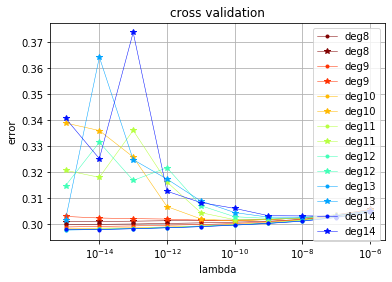

In [21]:
cross_validation_visualization(degrees, rmse_tr_ri, rmse_te_ri, lambdas)

In [22]:
idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-15

degree*=8

rmse train=0.29985216619891497

rmse test=0.3010249174628823


#### Bias-variance decomposition

In [54]:
%whos

Variable                                    Type           Data/Info
--------------------------------------------------------------------
DATA_TEST_PATH                              str            ../data/test.csv
DATA_TRAIN_PATH                             str            ../data/train.csv
OUTPUT_PATH                                 str            ../data/submission_deg0-11_deg1-13_deg2-9.csv
ax                                          AxesSubplot    AxesSubplot(0.125,0.125;0.775x0.755)
batch_iter                                  function       <function batch_iter at 0x00000000115DD828>
bias_variance_decomposition_visualization   function       <function bias_variance_d<...>on at 0x00000000115DDB88>
build_interaction                           function       <function build_interacti<...>on at 0x00000000115DCD38>
build_k_indices                             function       <function build_k_indices at 0x00000000115DD9D8>
build_poly                                  function       <functio

In [24]:
ratio_train = 0.1
seeds = range(50)

In [25]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*mse_tr)
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*mse_te)

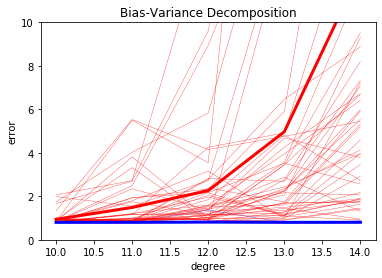

In [26]:
bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

Based on the plot above, change the value of `degree_ri` manually. 

In [23]:
tX_poly = build_poly(tX, degree_ri)
            
w_ri, mse_ri = ridge_regression(y, tX_poly, lambda_ri)

print("final w* shape={w}\n\nfinal degree*={degree}\n\nfinal lambda*={lambda_}\n\nmse={loss}".format(w=w_ri.shape, \
            degree=degree_ri, lambda_=lambda_ri, loss = mse_ri))

final w* shape=(233,)

final degree*=8

final lambda*=1e-15

mse=0.2999682836907512


### Jet sub-datasets

#### Cross-validation for hyperparameter selection

In [10]:
seed = 1
k_fold = 4
lambdas = np.logspace(-15, -6, 10)
degrees = range(8, 15)

k_indices = build_k_indices(y_jet0, k_fold, seed)
rmse_tr_ri, rmse_te_ri = cross_validation(y_jet0, tX_jet0, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = False)

idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-11

degree*=11

rmse train=0.24798111036097564

rmse test=0.24909543120238553


In [11]:
k_indices = build_k_indices(y_jet1, k_fold, seed)
rmse_tr_ri, rmse_te_ri = cross_validation(y_jet1, tX_jet1, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = False)

idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-10

degree*=13

rmse train=0.350178915128467

rmse test=0.3524122883195787


In [12]:
k_indices = build_k_indices(y_jet2, k_fold, seed)
rmse_tr_ri, rmse_te_ri = cross_validation(y_jet2, tX_jet2, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = False)

idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-09

degree*=9

rmse train=0.32705236595014053

rmse test=0.32882095216953927


In [14]:
tX0_poly = build_poly(tX_jet0, 11)    
w0_ri, mse0_ri = ridge_regression(y_jet0, tX0_poly, 1e-11)

tX1_poly = build_poly(tX_jet1, 13)    
w1_ri, mse1_ri = ridge_regression(y_jet1, tX1_poly, 1e-10)

tX2_poly = build_poly(tX_jet2, 9)    
w2_ri, mse2_ri = ridge_regression(y_jet2, tX2_poly, 1e-09)

## Logistic regression

### Full dataset

In [50]:
y = np.where(y==-1, 0, y)
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)

In [51]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(y, tX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:227: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


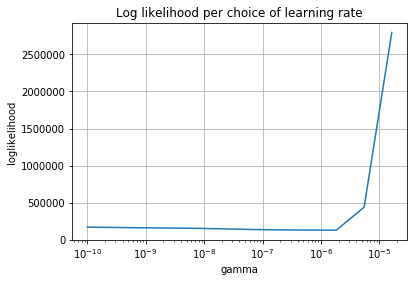

In [52]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [53]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

w* =[ 0.35960283 -1.77795302 -0.69426252  0.18748961  0.08607187  0.2542231
  0.13081494  0.28093011 -0.26591137  0.54030882  0.02801568  0.35354155
  0.15680455  1.51579065  0.14149669  0.12233889 -0.07234297  0.14212407
  0.16182888  0.09098316  0.14229663 -0.11125254 -0.2339899   0.14511142
  0.14671375 -1.51818866  0.15031418  0.14266557 -0.60556599]

loglikelihood loss=129922.80482931486

gamma=1.8329807108324337e-06


#### Cross-validation for hyperparameter determination

In [55]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas=[0], ml_function = 'lr', max_iters = 1000, gamma = gamma_lr)

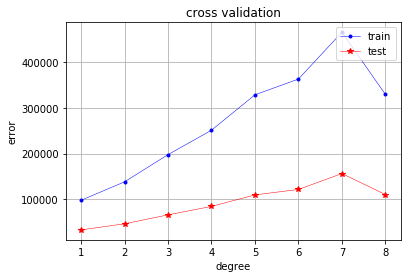

In [56]:
cross_validation_visualization(degrees, loss_tr_lr, loss_te_lr)

In [57]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmin(loss_te_lr)

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}".format(
    degree=degree_ri, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx]))

degree*=9

loglikelihood train=97464.99732658644

loglikelihood test=32492.581064100785


## Regularized logistic regression

### Full dataset

In [58]:
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
lambda_rlr =lambda_ri

In [59]:
losses_rlr = np.empty(len(gammas))
ws_rlr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = reg_logistic_regression(y, tX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr[idx] = loss
    ws_rlr[idx, :] = w

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:248: RuntimeWarning: divide by zero encountered in log
  w = np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))


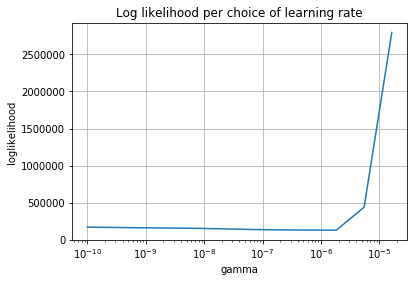

In [60]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [61]:
idx = np.nanargmin(losses_rlr)

w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=losses_rlr[idx], gamma = gamma_rlr))

w* =[ 0.35960283 -1.77795302 -0.69426252  0.18748961  0.08607187  0.2542231
  0.13081494  0.28093011 -0.26591137  0.54030882  0.02801568  0.35354155
  0.15680455  1.51579065  0.14149669  0.12233889 -0.07234297  0.14212407
  0.16182888  0.09098316  0.14229663 -0.11125254 -0.2339899   0.14511142
  0.14671375 -1.51818866  0.15031418  0.14266557 -0.60556599]

loglikelihood loss=129922.80482931486

gamma=1.8329807108324337e-06


#### Cross-validation hyperparameter selection

In [62]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 10)
degrees = range(3, 12)

k_indices = build_k_indices(y, k_fold, seed)

In [ ]:
loss_tr_rlr, loss_te_rlr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas, ml_function = 'rlr', max_iters = 500, gamma = gamma_rlr)

In [ ]:
cross_validation_visualization(degrees, loss_tr_rlr, loss_te_rlr, lambdas)

In [ ]:
idx = np.unravel_index(np.nanargmin(loss_te_rlr), loss_te_rlr.shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("lambda* ={lambda_}n\ndegree*={degree}\n\nloglikelihood train={log_tr}\n\nloglikelihood test={log_te}".format(
    lambda_=lambda_rlr, degree=degree_rlr, log_tr=loss_tr_rlr[idx], log_te=loss_te_rlr[idx]))

#### Bias-variance decomposition

In [149]:
ratio_train = 0.1
seeds = range(50)
degrees = range(1, 9)
lambda_rlr = lambda_ri

In [150]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        

    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:55: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


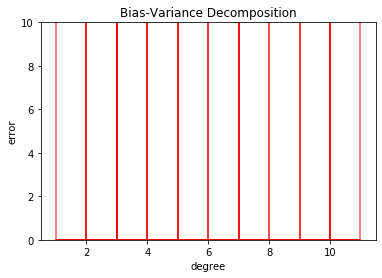

In [151]:
bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

Based on the plot above, change the value of `degree_rlr` manually. 

In [ ]:
tX_poly = build_poly(tX, degree_rlr)
initial_w = np.empty(tX_poly.shape[1])            
w_rlr, log_rlr = reg_logistic_regression(y, tX_poly, lambda_rlr, initial_w, max_iters, gamma_rlr)

print("final w* shape={w}\n\nfinal degree*={degree}\n\nfinal lambda*={lambda_}\n\nlog-likelihood={loss}".format(w=w_rlr.shape, \
            degree=degree_rlr, lambda_=lambda_rlr, loss = log_rlr))

##### Save computed variables

In [158]:
#save the calculated variables to keep them without having to re-run everything
# w_ls, w_gd, gamma_gd, w_sgd, gamma_sgd, w_ri, degree_ri, lambda_ri
# w_lr, gamma_lr, w_rlr, gamma_rlr, lambda_rlr, degree_rlr
ws = (w_ls, w_gd, w_sgd, w_ri, w_lr, w_rlr)
degs = (degree_ri , degree_rlr)
gammas = (gamma_gd, gamma_sgd, gamma_lr, gamma_rlr)
lambdas = (lambda_ri, lambda_rlr)

np.savetxt('weights.txt', ws, fmt='%s', delimiter=',', newline='\n')
np.savetxt('degrees.txt', degs, fmt='%s', delimiter=',', newline='\n')
np.savetxt('gammas.txt', gammas, fmt='%s', delimiter=',', newline='\n')
np.savetxt('lambdas.txt', lambdas, fmt='%s', delimiter=',', newline='\n')

# Generate predictions and save ouput in csv format for submission:

In [22]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

##### Full dataset

In [18]:
weights = w_ri
#weights = np.insert(weights, rmX, 0, axis = 0)
tX_test = np.delete(tX_test, rmX, axis=1)
# keep only columns that do not have too much missing data
tX_test, _ = train_data_formatting(tX_test, degree = 1, cutoff = 1.0, 
                      imputation = impute_median, interaction = False)
tX_test = np.apply_along_axis(standardize, 1, tX_test)
tX_poly = build_poly(tX_test, 12)

In [19]:
OUTPUT_PATH = '../data/submission.csv'
y_pred = predict_labels(weights, tX_poly)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

##### Jet sub-datasets

In [37]:
y_test = np.zeros(tX_test.shape[0])
idx_test0, y_test0, tX_test0, idx_test1, y_test1, tX_test1, idx_test2, y_test2, tX_test2 = separate_jet(y_test, tX_test)

In [38]:
# apply pre-processing to dataset jet0
tX_test0 = np.delete(tX_test0, rmX_jet0, axis=1)
tX_test0, _ = train_data_formatting(tX_test0, degree = 1, cutoff = 1.0, imputation = impute_median, interaction = False)
tX_test0[np.isnan(tX_test0)] = 0
tX_test0 = np.apply_along_axis(standardize, 1, tX_test0)
tX_test0_poly = build_poly(tX_test0, 11)

# apply pre-processing to dataset jet1
tX_test1 = np.delete(tX_test1, rmX_jet1, axis=1)
tX_test1, _ = train_data_formatting(tX_test1, degree = 1, cutoff = 1.0, imputation = impute_median, interaction = False)
tX_test1 = np.apply_along_axis(standardize, 1, tX_test1)
tX_test1_poly = build_poly(tX_test1, 13)    

# apply pre-processing to dataset jet2
tX_test2 = np.delete(tX_test2, rmX_jet2, axis=1)
tX_test2, _ = train_data_formatting(tX_test2, degree = 1, cutoff = 1.0, imputation = impute_median, interaction = False)
tX_test2 = np.apply_along_axis(standardize, 1, tX_test2)
tX_test2_poly = build_poly(tX_test2, 9) 

In [39]:
print(w0_ri.shape, w1_ri.shape, w2_ri.shape)
print(tX_test0_poly.shape[1], tX_test1_poly.shape[1], tX_test2_poly.shape[1])

(210,) (287,) (262,)
210 287 262


In [40]:
OUTPUT_PATH = '../data/submission_deg0-11_deg1-13_deg2-9.csv'
y_test0 = predict_labels(w0_ri, tX_test0_poly)
y_test1 = predict_labels(w1_ri, tX_test1_poly)
y_test2 = predict_labels(w2_ri, tX_test2_poly)
y_pred = merge_jet(idx_test0, y_test0, idx_test1, y_test1, idx_test2, y_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)